In [450]:
#!pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118

In [451]:
#!pip install torchdata==0.6.0

In [452]:
#!pip install torchtext==0.15.1

In [453]:
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math
import numpy as np

In [454]:
torch.__version__

'2.1.1+cpu'

In [455]:
class BinaryClassification(nn.Module):
  def __init__(self, embed_size, device):
    super(BinaryClassification, self).__init__()
    # Number of input features is embed_size.
    self.layer_1 = nn.Linear(embed_size, 64)
    self.layer_2 = nn.Linear(64, 64)
    self.layer_out = nn.Linear(64, 1)

    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.1)
    self.batchnorm1 = nn.BatchNorm1d(64)
    self.batchnorm2 = nn.BatchNorm1d(64)
    self.device = device

  def forward(self, inputs):
    # print("start binary classification")
    # print(inputs.shape)
    # print(inputs)
    x = self.relu(self.layer_1(inputs))
    x = self.batchnorm1(x)
    x = self.relu(self.layer_2(x))
    x = self.batchnorm2(x)
    x = self.dropout(x)
    x = self.layer_out(x)
    #if math.isnan (x[0][0]):
    #  print(src)

    return x

In [456]:
class Classifier(nn.Module):
  def __init__(self, d_model, seq_len, nhead, dim_feedforward, nlayers, device, dropout = 0.5):
    super(Classifier, self).__init__()
    self.d_model = d_model
    self.seq_len = seq_len
    self.nhead = nhead
    self.dim_feedforward = dim_feedforward
    self.nlayers = nlayers
    self.device = device
    #self.pos_encoder = PositionalEncoding(d_model, dropout)
    self.position_embedding = nn.Embedding(seq_len, d_model)
    encoder_layer = TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
    self.encoder = TransformerEncoder(encoder_layer, nlayers)
    self.binary_classifier = BinaryClassification(seq_len*d_model, device)


  def forward(self, src: Tensor) -> Tensor:
    # print("Classifier forwrd")
    """
    Args:
        src: Tensor, shape [seq_len, batch_size]
        src_mask: Tensor, shape [seq_len, seq_len]
    Returns:
        output Tensor of shape [seq_len, batch_size, ntoken]
    """
    N, seq_length, embed_size = src.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device)

    # print(f"src before positional embeddings: {src.shape}")
    src_ = src + self.position_embedding(positions)
    # print(f"src after positional embeddings: {src_.shape}")
    # print(f"src after positional embeddings: {src.shape}")
    # print(src_)
    # print("before encoder")
    output = self.encoder(src_)
    # print(f"encoder output shape: {output.shape}")
    # print(output[0])
    # print(output)
    # print("after encoder")
    output = self.binary_classifier(torch.reshape(output, (N, seq_length*embed_size))) ##
    # output_tx_f = torch.reshape(output, (N, seq_length*embed_size))
    # output = self.binary_classifier(torch.cat((output_tx_f), dim=1)) ##
    return output

In [457]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [458]:
#hyperparameters
dim_feedforward=16
#dim_feedforward=32
nlayers_tx=8

In [459]:
model = Classifier(d_model=11, seq_len=108, nhead=11, dim_feedforward=8, nlayers=8, device=device)
model.to(device)

c:\Users\sandu\Desktop\sem7\fyp\App\.venv\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Classifier(
  (position_embedding): Embedding(108, 11)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=11, out_features=11, bias=True)
        )
        (linear1): Linear(in_features=11, out_features=8, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=8, out_features=11, bias=True)
        (norm1): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((11,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
    )
  )
  (binary_classifier): BinaryClassification(
    (layer_1): Linear(in_features=1188, out_features=64, bias=True)
    (layer_2): Linear(in_features=64, out_features=64, bias=True)
    (layer_out): Linear(in_features=64, out_features=1, bias=True)
    

In [460]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [461]:
from sklearn.model_selection import train_test_split

In [462]:
# from google.colab import drive
# drive.mount('/content/drive')

In [463]:
# %cd /content/drive/My Drive/FYP_Data/Ablation

In [464]:
x = np.load("data\other\data.npy")
y = np.load("data\other\labels.npy")

In [465]:
print(x.shape)
print(y.shape)

(301, 108, 11)
(301,)


In [466]:
print(x[:5])

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   2.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   1.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   1.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 0.00000000e+00]]

 [[6.25000000e-01 6.25000000e-01 1.08000000e+20 ... 8.00000000e+00
   2.00000000e+00 1.00000000e+01]
  [1.00000000e+00 1.00000000e+00 1.00000000e+19 ... 9.00000000e+00
   1.00000000e+00 1.00000000e+01]
  [5.71428571e-01 5.71428571e-01 1.90000000e+19 ... 7.00000000e+00
   1.00000000e+00 1.00000000e+01]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.00000000e+00
   0.00000

In [467]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming you have loaded your data into a variable called data_array
# data_array should be of shape (301, 108, 11)

# Reshape the array to (301*108, 11) for normalization
reshaped_data = x.reshape((-1, 11))

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the reshaped data and transform it
normalized_data = scaler.fit_transform(reshaped_data)

# Reshape the normalized data back to the original shape
normalized_data_array = normalized_data.reshape(x.shape)

# Now, normalized_data_array contains the normalized data with shape (301, 108, 11)
print(normalized_data_array[:5])

[[[-1.02945209e-01 -1.14356860e-01 -1.38146329e-02 ... -2.37866691e-01
    6.17300954e+00 -2.28408205e-01]
  [-1.02945209e-01 -1.14356860e-01 -1.38146329e-02 ... -2.37866691e-01
    2.93045142e+00 -2.28408205e-01]
  [-1.02945209e-01 -1.14356860e-01 -1.38146329e-02 ... -2.37866691e-01
    2.93045142e+00 -2.28408205e-01]
  ...
  [-1.02945209e-01 -1.14356860e-01 -1.38146329e-02 ... -2.37866691e-01
   -3.12106692e-01 -2.28408205e-01]
  [-1.02945209e-01 -1.14356860e-01 -1.38146329e-02 ... -2.37866691e-01
   -3.12106692e-01 -2.28408205e-01]
  [-1.02945209e-01 -1.14356860e-01 -1.38146329e-02 ... -2.37866691e-01
   -3.12106692e-01 -2.28408205e-01]]

 [[ 8.86766055e+00  8.05507759e+00 -4.84967205e-03 ...  6.99221315e+00
    6.17300954e+00  4.61193986e+00]
  [ 1.42500240e+01  1.29567383e+01 -1.29845439e-02 ...  7.89597313e+00
    2.93045142e+00  4.61193986e+00]
  [ 8.09875148e+00  7.35484035e+00 -1.22374638e-02 ...  6.08845317e+00
    2.93045142e+00  4.61193986e+00]
  ...
  [-1.02945209e-01 -1.1

In [468]:
X, X_test, Y, y_test = train_test_split(normalized_data_array, y, test_size=0.1, random_state=42) #test split

In [469]:
np.save("X_test.npy",X_test)
np.save("y_test.npy",y_test)

In [470]:
#load test
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [471]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42) #validation split

In [472]:
np.save("X_train.npy",X_train)
np.save("y_train.npy",y_train)
np.save("X_val.npy",X_val)
np.save("y_val.npy",y_val)

In [473]:
#load train val
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_val = np.load("X_val.npy", allow_pickle=True)
y_val = np.load("y_val.npy", allow_pickle=True)

In [474]:
print(X_train.shape)

(243, 108, 11)


In [475]:
X_train = X_train[:19656]

In [476]:
print(X_val.shape)

(27, 108, 11)


In [477]:
X_val = X_val[:2184]

In [478]:
print(X_test.shape)

(31, 108, 11)


In [479]:
print(np.sum(y_train)/y_train.shape[0])
print(np.sum(y_val)/y_val.shape[0])
print(np.sum(y_test)/y_test.shape[0])

0.2962962962962963
0.4074074074074074
0.45161290322580644


In [480]:
from torch.utils.data import Dataset, DataLoader

In [481]:
## train data
from sklearn import preprocessing
class TrainData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


train_data = TrainData(X_train, y_train)

## val data
class ValData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


val_data = ValData(X_val, y_val)

## test data
class TestData(Dataset):

    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__ (self):
        return len(self.X_data)


test_data = TestData(X_test, y_test)

In [482]:
EPOCHS = 50
BATCH_SIZE = 8
LEARNING_RATE = 0.001

In [483]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [484]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [485]:
print(len(train_loader))
print(train_loader)

31


In [486]:

for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for X_batch, y_batch in train_loader:
        #print("w.requires_grad:",X_batch.requires_grad)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        y_pred = model(X_batch.float())
        # print(f"y_pred = {y_pred}")
        #y_pred = (y_pred>0.5).float()
        #print(f"y_pred = {y_pred}")
        #print(f"y_batch.unsqueeze(1) = {y_batch.unsqueeze(1)}")

        loss = criterion(y_pred.float(), y_batch.unsqueeze(1).float())
        acc = binary_acc(y_pred.float(), y_batch.unsqueeze(1).float())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    val_loss = 0
    val_accuracy = 0
    model.eval()
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch.float())
        loss = criterion(y_pred.float(), y_batch.unsqueeze(1).float())
        acc = binary_acc(y_pred.float(), y_batch.unsqueeze(1).float())
        val_loss += loss.item()
        val_accuracy += acc.item()

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} | Val_Loss: {val_loss/len(test_loader):.5f} | Val_Acc: {val_accuracy/len(test_loader):.3f}')
    #print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

Epoch 001: | Loss: 0.72009 | Acc: 53.323 | Val_Loss: 0.67493 | Val_Acc: 58.065
Epoch 002: | Loss: 0.65573 | Acc: 59.742 | Val_Loss: 0.65779 | Val_Acc: 51.613
Epoch 003: | Loss: 0.62368 | Acc: 65.710 | Val_Loss: 0.64568 | Val_Acc: 61.290
Epoch 004: | Loss: 0.63162 | Acc: 66.032 | Val_Loss: 0.69703 | Val_Acc: 54.839
Epoch 005: | Loss: 0.61713 | Acc: 66.710 | Val_Loss: 0.64160 | Val_Acc: 61.290
Epoch 006: | Loss: 0.61819 | Acc: 67.710 | Val_Loss: 0.66834 | Val_Acc: 64.516
Epoch 007: | Loss: 0.58605 | Acc: 69.581 | Val_Loss: 0.69293 | Val_Acc: 48.387
Epoch 008: | Loss: 0.63136 | Acc: 64.645 | Val_Loss: 0.72882 | Val_Acc: 54.839
Epoch 009: | Loss: 0.61000 | Acc: 65.968 | Val_Loss: 0.71542 | Val_Acc: 54.839
Epoch 010: | Loss: 0.60883 | Acc: 69.645 | Val_Loss: 0.66094 | Val_Acc: 54.839
Epoch 011: | Loss: 0.61057 | Acc: 69.000 | Val_Loss: 0.73049 | Val_Acc: 54.839
Epoch 012: | Loss: 0.59768 | Acc: 69.548 | Val_Loss: 0.68688 | Val_Acc: 51.613
Epoch 013: | Loss: 0.60560 | Acc: 70.710 | Val_Loss:

In [ ]:
#PATH = './DeFi_Supervised_v1.pth'
#PATH = './DeFi_Ablation_v2.pth'
PATH = './DeFi_Ablation_v3.pth'
#torch.save(model, PATH)

In [ ]:
#PATH = './DeFi_Ablation_v1.pth'
#PATH = './DeFi_Ablation_v2.pth'
PATH = './DeFi_Ablation_v3.pth'
loaded_model = torch.load(PATH)
loaded_model.eval()

Classifier(
  (position_embedding): Embedding(108, 7)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=7, out_features=7, bias=True)
        )
        (linear1): Linear(in_features=7, out_features=8, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=8, out_features=7, bias=True)
        (norm1): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((7,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.5, inplace=False)
        (dropout2): Dropout(p=0.5, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=7, out_features=7, bias=True)
        )
        (linear1): Linear(in_features=7, out_features=8, bias=True)
        (dropout): Dro

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

In [ ]:
y_pred = []
y_true = []
sigmoid = nn.Sigmoid()

for X_batch, y_batch in test_loader:
        #print("w.requires_grad:",X_batch.requires_grad)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_batch_pred = torch.round(sigmoid(loaded_model(X_batch.float())))
        y_pred.extend(y_batch_pred.cpu().detach().numpy())
        y_true.extend(y_batch.cpu().detach().numpy())

In [ ]:
count_true = 0
for i in range(len(y_pred)):
  if y_true[i]==y_pred[i]:
    count_true+=1
acc = count_true/len(y_pred)
print(len(y_test))
print(acc)

2427
0.992583436341162


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
(tn, fp, fn, tp)

(2354, 4, 14, 55)

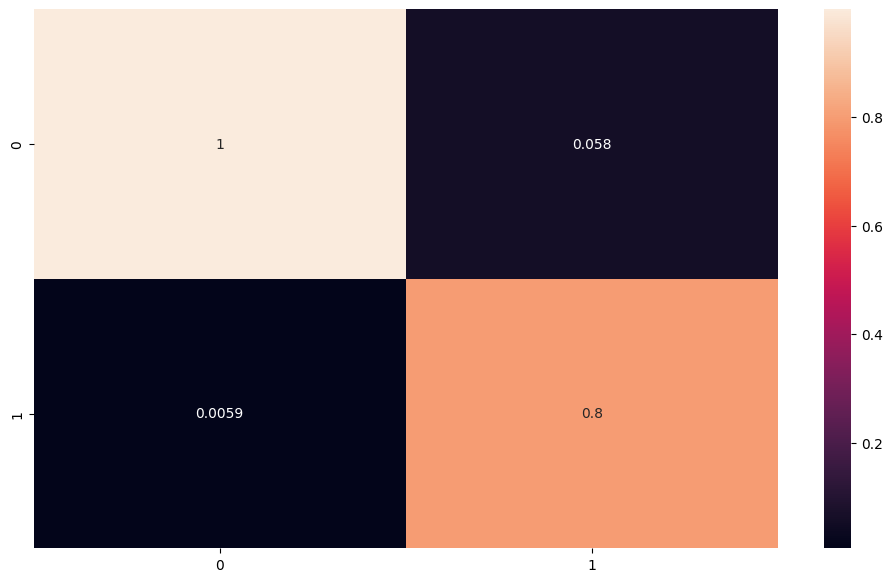

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = ['0','1'],
                     columns = ['0','1'])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

**Two token**

In [ ]:
#Anubis
ankh_x1 = np.load("ankh_full_x1.npy", allow_pickle=True)

In [ ]:
#500

for i in range(50,108):
  ankh_x1[i] = [0,0,0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.0071]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#750

for i in range(75,108):
  ankh_x1[i] = [0,0,0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.2284]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#850

for i in range(85,108):
  ankh_x1[i] = [0,0,0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9375]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#full

#for i in range(50,108):
#  ankh_x1[i] = [0,0,0,0,0,0,0]

print(ankh_x1.shape)
ankh_x1 = np.reshape(ankh_x1, (1, 108, 7))
print(ankh_x1.shape)

ankh_x1 = torch.from_numpy(ankh_x1)
ankh_x1 = ankh_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(ankh_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[7.5255e-07]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Sushi
sushi_x1 = np.load("sushi_full_x1.npy", allow_pickle=True)

In [ ]:
#500

for i in range(50,108):
  sushi_x1[i] = [0,0,0,0,0,0,0]

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.0580]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#750

for i in range(75,108):
  sushi_x1[i] = [0,0,0,0,0,0,0]

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9919]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#850

for i in range(85,108):
  sushi_x1[i] = [0,0,0,0,0,0,0]

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9957]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Full

print(sushi_x1.shape)
sushi_x1 = np.reshape(sushi_x1, (1, 108, 7))
print(sushi_x1.shape)

sushi_x1 = torch.from_numpy(sushi_x1)
sushi_x1 = sushi_x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(sushi_x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

**APE**

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving ape_full_x1.npy to ape_full_x1.npy


In [ ]:
#Ape
x1 = np.load("ape_full_x1.npy", allow_pickle=True)

In [ ]:
#500

for i in range(50,108):
  x1[i] = [0,0,0,0,0,0,0]

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.0006]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#750

for i in range(75,108):
  x1[i] = [0,0,0,0,0,0,0]

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9763]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#850

for i in range(85,108):
  x1[i] = [0,0,0,0,0,0,0]

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[0.9997]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
#Full

print(x1.shape)
x1 = np.reshape(x1, (1, 108, 7))
print(x1.shape)

x1 = torch.from_numpy(x1)
x1 = x1.to(device)

sigmoid = nn.Sigmoid()
val = sigmoid(loaded_model(x1.float()))
print(val)
torch.round(val)

(108, 7)
(1, 108, 7)
tensor([[8.2050e-08]], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward0>)